In [1]:
import torch 
import pandas as pd 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(torch.cuda.get_device_name(), '파이토치버전 : ',torch.__version__)

NVIDIA GeForce GTX 1650 파이토치버전 :  1.12.0


In [8]:
BATCH_SIZE = 128
EPOCHS = 100

In [9]:
from sklearn.utils import shuffle


train_dataset = datasets.MNIST(root='../../data/MNIST/',
                                download=True,
                                train = True,
                                transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(root='../../data/MNIST/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            shuffle=False,
                                            batch_size= BATCH_SIZE
)

In [10]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


In [13]:
len(train_loader.dataset)

60000

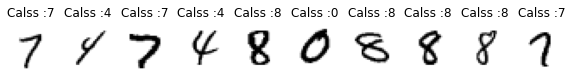

In [25]:
pltsize = 1
plt.figure(figsize=(pltsize * 10, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap= 'gray_r')
    plt.title('Calss :' + str(y_train[i].item()))

In [108]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.log_softmax(x)
        return x

In [109]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)


In [110]:
def train(model, train_loader, optimizer, log_intervals=100):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0:
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_Loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100 * batch_idx / len(train_loader),
                loss.item()
            ))

In [111]:
X_train[0].max(1, keepdim=True)[1]

tensor([[[ 0,  0,  0,  0,  0,  0,  0, 10, 10, 10, 10, 10, 21, 19, 17,  9, 14,
           8,  8,  8,  8,  0,  0,  0,  0,  0,  0,  0]]])

In [112]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0 
    test_loss = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [113]:
best_accuracy = 0
es = 0
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss , test_accuracy =  evaluate(model, test_loader)
    if test_accuracy > best_accuracy :
        best_model = model
        best_accuracy = test_accuracy
        es = 0
    else :
        es += 1
    if es == 30 :
        break
    print('\n[EPOCH : {}, \tTest_loss : {:.4f}, \tTest_Accuracy : {:.2f}%\n'.format(
        Epoch, test_loss, test_accuracy
    ))

C:\Users\Admin\AppData\Local\Temp\ipykernel_28520\2927173580.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train_Epoch : 1, [0 / 60000](0%)	Train_Loss : 2.303323
Train_Epoch : 1, [12800 / 60000](21%)	Train_Loss : 0.281603
Train_Epoch : 1, [25600 / 60000](43%)	Train_Loss : 0.178139
Train_Epoch : 1, [38400 / 60000](64%)	Train_Loss : 0.166107
Train_Epoch : 1, [51200 / 60000](85%)	Train_Loss : 0.181567

[EPOCH : 1, 	Test_loss : 0.0003, 	Test_Accuracy : 96.03%

Train_Epoch : 2, [0 / 60000](0%)	Train_Loss : 0.096749
Train_Epoch : 2, [12800 / 60000](21%)	Train_Loss : 0.281038
Train_Epoch : 2, [25600 / 60000](43%)	Train_Loss : 0.154026
Train_Epoch : 2, [38400 / 60000](64%)	Train_Loss : 0.016012
Train_Epoch : 2, [51200 / 60000](85%)	Train_Loss : 0.107075

[EPOCH : 2, 	Test_loss : 0.0000, 	Test_Accuracy : 96.92%

Train_Epoch : 3, [0 / 60000](0%)	Train_Loss : 0.084870
Train_Epoch : 3, [12800 / 60000](21%)	Train_Loss : 0.102346
Train_Epoch : 3, [25600 / 60000](43%)	Train_Loss : 0.133020
Train_Epoch : 3, [38400 / 60000](64%)	Train_Loss : 0.157771
Train_Epoch : 3, [51200 / 60000](85%)	Train_Loss : 0.1189

KeyboardInterrupt: 

In [114]:
print('최고 정확도 : ', best_accuracy)

최고 정확도 :  98.03
